# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
!pip install albumentations


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install labelme


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1.2 Collect Images Using OpenCV

In [2]:
import os
import time
import uuid
import cv2

In [4]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [7]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [8]:
!labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [6]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [12]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [13]:
images.as_numpy_iterator().next()

b'data\\images\\f949b082-a90a-11ed-bbec-e470b826a1c0.jpg'

In [14]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [15]:
images = images.map(load_image)

In [16]:
images.as_numpy_iterator().next()

array([[[121,  98,  92],
        [117,  94,  88],
        [109,  89,  82],
        ...,
        [103, 111, 113],
        [100, 110, 111],
        [100, 110, 111]],

       [[120,  95,  90],
        [115,  92,  86],
        [108,  88,  81],
        ...,
        [102, 110, 112],
        [102, 110, 112],
        [103, 111, 113]],

       [[125,  98,  91],
        [117,  92,  85],
        [109,  86,  78],
        ...,
        [105, 109, 112],
        [106, 110, 113],
        [108, 113, 116]],

       ...,

       [[ 80,  82,  94],
        [ 74,  76,  88],
        [ 73,  77,  89],
        ...,
        [ 97,  97,  99],
        [ 94,  94,  96],
        [ 91,  91,  93]],

       [[ 74,  77,  86],
        [ 73,  76,  85],
        [ 77,  81,  92],
        ...,
        [ 96,  95, 100],
        [ 94,  93,  98],
        [ 90,  89,  94]],

       [[ 77,  80,  89],
        [ 69,  72,  81],
        [ 68,  72,  83],
        ...,
        [ 94,  93,  98],
        [ 93,  92,  97],
        [ 90,  89,  94]]

In [17]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [19]:
plot_images = image_generator.next()

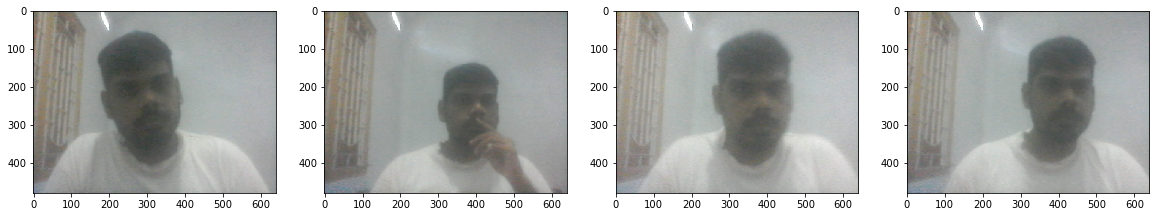

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 63 to train

In [ ]:
90*.15 # 14 and 13 to test and val

### 3.2 Move the Matching Labels

In [21]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [22]:
import albumentations as alb

In [23]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [26]:
img = cv2.imread(os.path.join('data','train', 'images','0a21d954-a90b-11ed-84f9-e470b826a1c0.jpg'))

In [27]:
with open(os.path.join('data', 'train', 'labels', '0a21d954-a90b-11ed-84f9-e470b826a1c0.json'), 'r') as f:
    label = json.load(f)

In [28]:
label['shapes'][0]['points']

[[159.23076923076923, 52.820512820512825],
 [411.02564102564105, 352.8205128205128]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [29]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [30]:
coords

[159.23076923076923, 52.820512820512825, 411.02564102564105, 352.8205128205128]

In [31]:
coords = list(np.divide(coords, [640,480,640,480]))

In [32]:
coords

[0.24879807692307693,
 0.11004273504273505,
 0.6422275641025641,
 0.735042735042735]

### 4.4 Apply Augmentations and View Results

In [33]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [34]:
augmented['bboxes'][0][2:]

(0.6905982905982906, 0.7796011396011396)

In [35]:
augmented['bboxes']

[(0.1310541310541311,
  0.11293447293447294,
  0.6905982905982906,
  0.7796011396011396)]

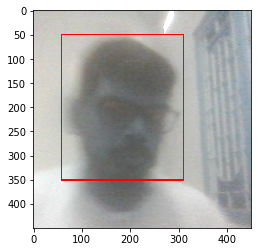

In [36]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [37]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [38]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [39]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [40]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [41]:
train_images.as_numpy_iterator().next()

array([[[0.11421569, 0.1254902 , 0.12598039],
        [0.11911765, 0.13039216, 0.13615195],
        [0.11372549, 0.13186274, 0.14362745],
        ...,
        [0.07481617, 0.07383578, 0.05667892],
        [0.07352941, 0.07616422, 0.06041666],
        [0.0533701 , 0.05643382, 0.04705882]],

       [[0.12677696, 0.13069853, 0.146875  ],
        [0.12941177, 0.1324755 , 0.14901961],
        [0.13333334, 0.12941177, 0.14901961],
        ...,
        [0.06568628, 0.07009804, 0.05147059],
        [0.05140932, 0.05839461, 0.04705882],
        [0.04362745, 0.04656863, 0.0372549 ]],

       [[0.11715686, 0.12892157, 0.14852941],
        [0.11862745, 0.12941177, 0.14852941],
        [0.1264093 , 0.13033088, 0.14601716],
        ...,
        [0.05833333, 0.06617647, 0.05441177],
        [0.05098039, 0.05882353, 0.04705882],
        [0.04981618, 0.05275735, 0.04834559]],

       ...,

       [[0.22205882, 0.22205882, 0.22205882],
        [0.22346814, 0.22444853, 0.22395833],
        [0.22738971, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [42]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [43]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [44]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [45]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [46]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.1722, 0.1266, 0.6304, 0.751 ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [47]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

### 7.2 Create Final Datasets (Images/Labels)

In [48]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [49]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [50]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [51]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.01385, 0.3013 , 0.4275 , 0.7515 ],
        [0.08716, 0.0907 , 0.6465 , 0.7573 ],
        [0.1339 , 0.1493 , 0.5874 , 0.7783 ],
        [0.5107 , 0.2544 , 0.8687 , 0.7124 ],
        [0.1567 , 0.2732 , 0.5215 , 0.762  ],
        [0.5815 , 0.283  , 0.9644 , 0.79   ],
        [0.5513 , 0.2379 , 1.     , 0.8774 ],
        [0.5835 , 0.1772 , 1.     , 0.806  ]], dtype=float16))

### 7.3 View Images and Annotations

In [52]:
data_samples = train.as_numpy_iterator()

In [53]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


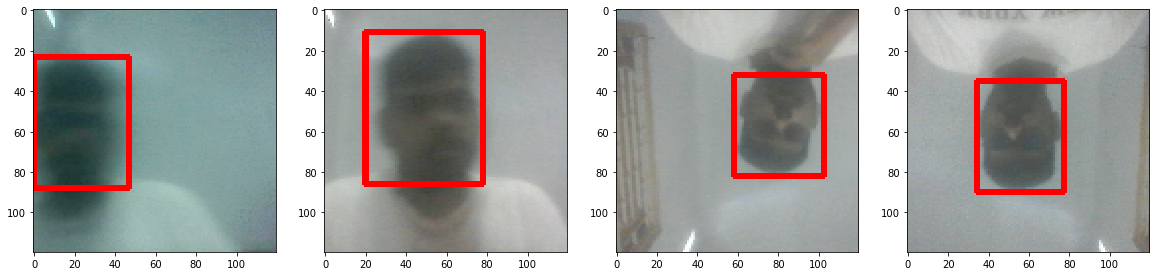

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [56]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 8s 0us/step


In [57]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [58]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [59]:
facetracker = build_model()

In [60]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [61]:
X, y = train.as_numpy_iterator().next()

In [62]:
X.shape

(8, 120, 120, 3)

In [63]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [64]:
classes, coords

(array([[0.4506643 ],
        [0.48264906],
        [0.5438857 ],
        [0.45345524],
        [0.51087046],
        [0.48091674],
        [0.4801128 ],
        [0.4334718 ]], dtype=float32),
 array([[0.67443097, 0.58518046, 0.6530348 , 0.43138495],
        [0.6866407 , 0.6113492 , 0.6642641 , 0.42887446],
        [0.66880953, 0.5476886 , 0.69934875, 0.4549538 ],
        [0.66715544, 0.6127075 , 0.670423  , 0.46415418],
        [0.6792046 , 0.5675653 , 0.67754734, 0.45039058],
        [0.67031896, 0.59521276, 0.6700849 , 0.450638  ],
        [0.6398104 , 0.5955777 , 0.66876215, 0.5055951 ],
        [0.687292  , 0.5996931 , 0.66108876, 0.45626   ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [65]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [67]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [68]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [69]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [70]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.555697>

In [71]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7373418>

In [72]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.555697>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [73]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [74]:
model = FaceTracker(facetracker)

In [75]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [76]:
logdir='logs'

In [77]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [78]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 1160s 2s/step - total_loss: 0.1848 - class_loss: 0.0298 - regress_loss: 0.1699 - val_total_loss: 0.1353 - val_class_loss: 0.0019 - val_regress_loss: 0.1344
Epoch 2/10
473/473 [==============================] - 1138s 2s/step - total_loss: 0.0435 - class_loss: 0.0074 - regress_loss: 0.0398 - val_total_loss: 0.0258 - val_class_loss: 6.2260e-05 - val_regress_loss: 0.0258
Epoch 3/10
473/473 [==============================] - 1248s 3s/step - total_loss: 0.0408 - class_loss: 0.0103 - regress_loss: 0.0356 - val_total_loss: 0.0494 - val_class_loss: 8.3816e-05 - val_regress_loss: 0.0494
Epoch 4/10
473/473 [==============================] - 1107s 2s/step - total_loss: 0.0220 - class_loss: 0.0039 - regress_loss: 0.0200 - val_total_loss: 0.0045 - val_class_loss: 5.8264e-06 - val_regress_loss: 0.0045
Epoch 5/10
473/473 [==============================] - 1133s 2s/step - total_loss: 0.0242 - class_loss: 0.0058 - regress_loss: 0.0213 - val_total_los

### 10.3 Plot Performance

In [79]:
hist.history

{'total_loss': [0.017521753907203674,
  0.0050970157608389854,
  0.004596777260303497,
  0.0023123305290937424,
  0.0018130718963220716,
  0.003383717965334654,
  0.0013733879895880818,
  0.014195510186254978,
  0.0052223908714950085,
  0.0014722574269399047],
 'class_loss': [0.001407347503118217,
  3.099589594057761e-05,
  0.0007830116664990783,
  6.968242087168619e-05,
  3.9013240893837065e-05,
  1.8477488765711314e-06,
  5.960470730315137e-07,
  3.624192686402239e-05,
  7.01853105056216e-06,
  1.3739094356424175e-05],
 'regress_loss': [0.016818080097436905,
  0.005081517621874809,
  0.004205271601676941,
  0.00227748928591609,
  0.0017935652285814285,
  0.0033827940933406353,
  0.0013730899663642049,
  0.014177389442920685,
  0.005218881648033857,
  0.001465387875214219],
 'val_total_loss': [0.13534000515937805,
  0.0258370079100132,
  0.049394845962524414,
  0.0044822306372225285,
  0.02992868982255459,
  0.013920174911618233,
  0.004418758675456047,
  0.030739378184080124,
  0.212

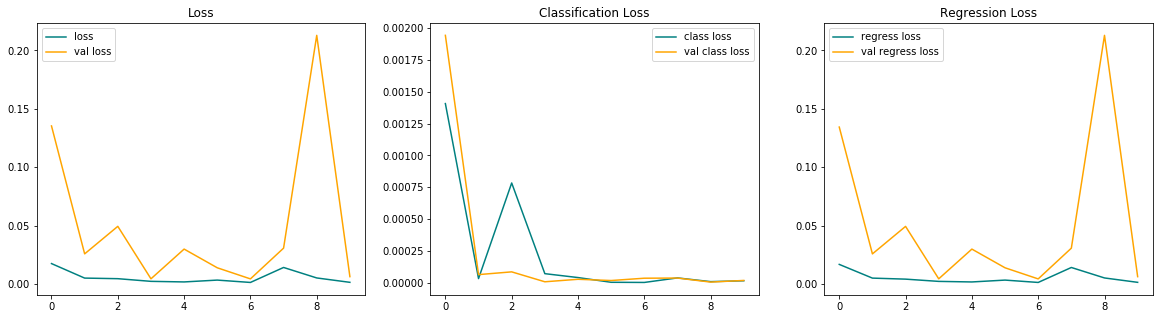

In [89]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [90]:
test_data = test.as_numpy_iterator()

In [91]:
test_sample = test_data.next()

In [92]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 820ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


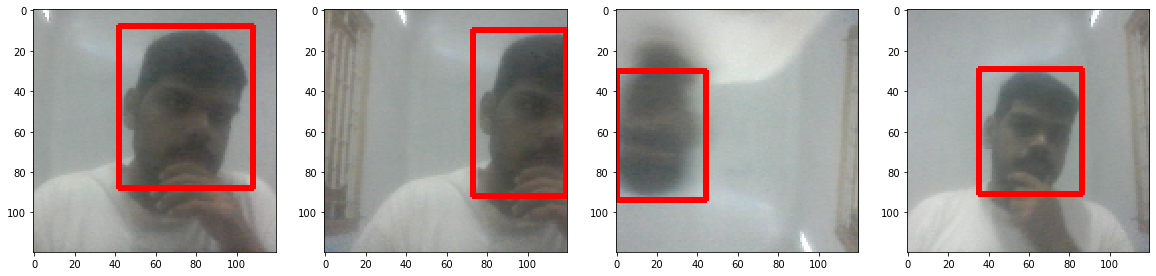

In [93]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [3]:
from tensorflow.keras.models import load_model

In [102]:
facetracker.compiled_metrics == None

True

In [103]:
facetracker.save('facetracker.h5')

In [4]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()